# Mobile Phone Price Prediction using Machine Learning

## Step 1: Importing Required Libraries and Models


In [420]:
# ============================
# Import Required Libraries
# ============================

# Data Handling
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import re

# Preprocessing & Utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Tabular Results
from tabulate import tabulate

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


## Step 2: Data Collection 

In [421]:
data = pd.read_csv('mobiles_dataset_2025.csv', encoding='latin1')
data = data.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle the dataset

## Step 3: Data Preprocessing

In [422]:
# Check for null value
data.isnull().sum()

Company Name            0
Model Name              0
Mobile Weight           0
RAM                     0
Front Camera            0
Back Camera             0
Processor               0
Battery Capacity        0
Screen Size             0
Launched Price (USA)    0
Launched Year           0
dtype: int64

In [423]:
# Helper function to clean numeric columns
def clean_numeric(series, remove_str="", round_to_int=False):
    cleaned = (
        series.astype(str)
        .str.replace(remove_str, "", regex=False)
        .str.replace("Not available", "", regex=False)
        .str.replace(",", "", regex=False)
        .str.extract(r"(\d+\.?\d*)")[0]   
    )
    cleaned = pd.to_numeric(cleaned, errors="coerce")
    
    if round_to_int:
        cleaned = cleaned.round().astype("Int64")  
    return cleaned

def extract_rom(model_name):
    model_name = str(model_name).upper()
    match_tb = re.search(r'(\d+)TB', model_name)
    if match_tb:
        return float(match_tb.group(1)) 
    match_gb = re.search(r'(\d+)GB', model_name)
    if match_gb:
        return float(match_gb.group(1)) / 1024
    return np.nan

print("Columns:", data.columns.tolist())

# RAM
if "RAM" in data.columns:
    data["RAM"] = clean_numeric(data["RAM"], remove_str="GB", round_to_int=True) / 4

# ROM
data['ROM'] = data['Model Name'].apply(extract_rom).apply(lambda x: x if not pd.isna(x) else np.nan)

data['ROM'] = data['ROM'].astype('Float64')
data['ROM'] = data['ROM'].fillna(data['ROM'].median())

# # Front Camera
if "Front Camera" in data.columns:
    data["Front Camera"] = clean_numeric(data["Front Camera"], remove_str="MP") / 10

# Back Camera
if "Back Camera" in data.columns:
    data["Back Camera"] = clean_numeric(data["Back Camera"], remove_str="MP") / 10

# Rear / Primary Camera (handle whichever exists)
for cam_col in ["Primary Camera", "Rear Camera", "Main Camera"]:
    if cam_col in data.columns:
        data[cam_col] = clean_numeric(data[cam_col], remove_str="MP")

# Battery
if "Battery Capacity" in data.columns:
    data["Battery Capacity"] = clean_numeric(data["Battery Capacity"], remove_str="mAh", round_to_int=True)
    data["Battery Capacity"] = data["Battery Capacity"] / 1000
if "Internal Storage" in data.columns:
    data["Internal Storage"] = clean_numeric(data["Internal Storage"], remove_str="GB", round_to_int=True)

# Weight
if "Mobile Weight" in data.columns:
    data["Mobile Weight"] = clean_numeric(data["Mobile Weight"], remove_str="g", round_to_int=True) / 100

# Screen Size
if "Screen Size" in data.columns:
    data["Screen Size"] = clean_numeric(data["Screen Size"], remove_str="inches")

# company Name
if 'Company Name' in data.columns:
    # decrease amount of Company Name only Apple, Samsung, Oppo, Honor
    company_counts = data['Company Name'].value_counts()
    
    top_companies = company_counts.head(5).index
    
    data['Company Simplified'] = data['Company Name'].apply(lambda x: x if x in top_companies else 'Other')
    
    # One-hot encode lại
    data = pd.get_dummies(data, columns=['Company Simplified'], prefix='Company', drop_first=False, dtype=int)

if "Processor" in data.columns:
    processor_texts = data["Processor"].fillna("").astype(str)

    vectorizer = TfidfVectorizer(stop_words='english', max_features=30)
    processor_tfidf = vectorizer.fit_transform(processor_texts)

    # Giảm còn 3 chiều đặc trưng
    pca = PCA(n_components=3, random_state=42)
    processor_pca = pca.fit_transform(processor_tfidf.toarray())

    processor_df = pd.DataFrame(
        processor_pca, columns=["Processor_vec1", "Processor_vec2", "Processor_vec3"]
    )

    data = pd.concat([data.reset_index(drop=True), processor_df], axis=1)

print(data.columns)

def clean_usa_price(price_str):
    if pd.isna(price_str):
        return np.nan
    
    price_str = str(price_str).strip()
    
    price_str = price_str.replace("USD", "").replace("$", "").strip()
    
    price_str = price_str.replace(" ", "")
    
    if price_str in ["", "Not available", "not available", "N/A", "None"]:
        return np.nan
    
    try:
        comma_count = price_str.count(',')
        
        if comma_count == 0:
            return float(price_str)
        elif comma_count == 1:
            comma_pos = price_str.index(',')
            digits_after = len(price_str) - comma_pos - 1
            
            if digits_after == 2:
                price_str = price_str.replace(',', '.')
            else:
                price_str = price_str.replace(',', '')
        else:
            price_str = price_str.replace(',', '')
        
        value = float(price_str)
        
        if 99 <= value <= 2000:
            return value
        else:
            return np.nan 
    except:
        return np.nan

# clean Launch price USA
if "Launched Price (USA)" in data.columns:
    print("Cleaning USA prices...")
    print(f"Before: {data['Launched Price (USA)'].head(10).tolist()}")

    data["Launched Price (USA)"] = data["Launched Price (USA)"].apply(clean_usa_price)

    print(f"After: {data['Launched Price (USA)'].head(10).tolist()}")
    print(f"\nUSA Price Statistics:")
    print(data["Launched Price (USA)"].describe())
    print(f"\nInvalid/Placeholder values: {data['Launched Price (USA)'].isna().sum()}")


Columns: ['Company Name', 'Model Name', 'Mobile Weight', 'RAM', 'Front Camera', 'Back Camera', 'Processor', 'Battery Capacity', 'Screen Size', 'Launched Price (USA)', 'Launched Year']
Index(['Company Name', 'Model Name', 'Mobile Weight', 'RAM', 'Front Camera',
       'Back Camera', 'Processor', 'Battery Capacity', 'Screen Size',
       'Launched Price (USA)', 'Launched Year', 'ROM', 'Company_Apple',
       'Company_Honor', 'Company_Oppo', 'Company_Other', 'Company_Samsung',
       'Company_Vivo', 'Processor_vec1', 'Processor_vec2', 'Processor_vec3'],
      dtype='object')
Cleaning USA prices...
Before: ['USD 379', 'USD 139', 'USD 1,099', 'USD 549', 'USD 749', 'USD 699', 'USD 799', 'USD 230', 'USD 360', 'USD 199']
After: [379.0, 139.0, 1099.0, 549.0, 749.0, 699.0, 799.0, 230.0, 360.0, 199.0]

USA Price Statistics:
count     923.000000
mean      568.419155
std       385.744473
min        79.000000
25%       250.000000
50%       449.000000
75%       799.000000
max      1899.000000
Name: L

In [424]:
data.describe()

,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Price (USA),Launched Year,ROM,Company_Apple,Company_Honor,Company_Oppo,Company_Other,Company_Samsung,Company_Vivo,Processor_vec1,Processor_vec2,Processor_vec3
count,930.0,930.0,930.000000,930.00000,930.0,930.000000,923.000000,930.000000,930.0,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,9.300000e+02,9.300000e+02,9.300000e+02
mean,2.282667,1.946505,1.816301,4.67643,5.026163,7.083796,568.419155,2022.193548,0.194204,0.104301,0.097849,0.138710,0.472043,0.094624,0.092473,-5.386372e-16,-1.050534e-16,-3.266205e-16
std,1.054316,0.794407,1.198623,3.10699,1.355548,1.533690,385.744473,1.862080,0.141983,0.305815,0.297271,0.345829,0.499486,0.292852,0.289849,4.262734e-01,2.988981e-01,2.751127e-01
min,1.35,0.25,0.200000,0.50000,2.0,5.000000,79.000000,2014.000000,0.015625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.504965e-01,-7.102952e-01,-5.199964e-01
25%,1.85,1.5,0.800000,1.60000,4.4025,6.500000,250.000000,2021.000000,0.125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-4.038693e-01,-1.058121e-01,-1.465504e-01
50%,1.94,2.0,1.600000,5.00000,5.0,6.670000,449.000000,2023.000000,0.125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-8.921112e-02,5.097489e-02,-2.363566e-02
75%,2.08,2.0,3.200000,5.00000,5.09125,6.780000,799.000000,2024.000000,0.25,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.586492e-01,1.931551e-01,3.091909e-02
max,7.32,4.0,6.000000,20.00000,11.2,14.600000,1899.000000,2025.000000,2.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.284119e-01,4.572660e-01,7.475682e-01


In [425]:
# Remove the duplicate values
data.drop_duplicates(inplace=True)
data.shape
data.head()

,Company Name,Model Name,Mobile Weight,RAM,Front Camera,Back Camera,Processor,Battery Capacity,Screen Size,Launched Price (USA),...,ROM,Company_Apple,Company_Honor,Company_Oppo,Company_Other,Company_Samsung,Company_Vivo,Processor_vec1,Processor_vec2,Processor_vec3
0,Infinix,Hot 50 Pro+,1.96,3.0,3.2,10.8,MediaTek Dimensity 9200,5.3,6.90,379.0,...,0.125,0,0,0,1,0,0,-0.402821,0.186216,-0.134345
1,Nokia,C32 64GB,1.99,0.75,0.8,5.0,Unisoc SC9863A,5.0,6.52,139.0,...,0.0625,0,0,0,1,0,0,-0.080015,-0.290803,-0.071201
2,Apple,iPhone 14 Pro 128GB,2.06,1.5,1.2,4.8,A16 Bionic,4.2,6.10,1099.0,...,0.125,1,0,0,0,0,0,-0.094269,-0.558327,-0.223110
3,Oppo,Reno8 Pro 5G 256GB,1.83,3.0,3.2,5.0,Dimensity 8100,4.5,6.70,549.0,...,0.25,0,0,1,0,0,0,-0.476122,0.381879,-0.519996
4,OnePlus,OnePlus 10T 256GB,2.03,3.0,1.6,5.0,Snapdragon 8+ Gen 1,4.5,6.70,749.0,...,0.25,0,0,0,1,0,0,0.628412,0.242371,0.051308


## Step 4: Initial Data Exploration & Visualization

In [426]:
data.describe()

,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Price (USA),Launched Year,ROM,Company_Apple,Company_Honor,Company_Oppo,Company_Other,Company_Samsung,Company_Vivo,Processor_vec1,Processor_vec2,Processor_vec3
count,915.0,915.0,915.000000,915.000000,915.0,915.000000,908.000000,915.000000,915.0,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000,915.000000
mean,2.289137,1.947541,1.816678,4.649158,5.030281,7.092678,573.706916,2022.205464,0.194723,0.106011,0.099454,0.125683,0.478689,0.096175,0.093989,0.000783,-0.001800,0.000320
std,1.061641,0.797361,1.204347,3.112418,1.365572,1.544578,386.605655,1.869182,0.142852,0.308020,0.299434,0.331673,0.499819,0.294992,0.291973,0.426252,0.300214,0.275963
min,1.35,0.25,0.200000,0.500000,2.0,5.000000,79.000000,2014.000000,0.015625,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.650497,-0.710295,-0.519996
25%,1.85,1.5,0.800000,1.300000,4.4,6.500000,266.750000,2021.000000,0.125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.403869,-0.113062,-0.145094
50%,1.95,2.0,1.600000,5.000000,5.0,6.670000,449.000000,2023.000000,0.125,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.089211,0.050975,-0.023636
75%,2.09,2.0,3.200000,5.000000,5.1,6.780000,811.500000,2024.000000,0.25,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.458649,0.193155,0.030919
max,7.32,4.0,6.000000,20.000000,11.2,14.600000,1899.000000,2025.000000,2.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.628412,0.457266,0.747568


Hệ số tương quan giữa năm ra mắt và giá ra mắt (USA): 0.034
    Launched Year  Launched Price (USA)
0            2014            169.000000
1            2016            211.000000
2            2017            505.666667
3            2018            630.904762
4            2019            609.434783
5            2020            585.326531
6            2021            501.372549
7            2022            580.677379
8            2023            590.939227
9            2024            588.483136
10           2025            428.666667


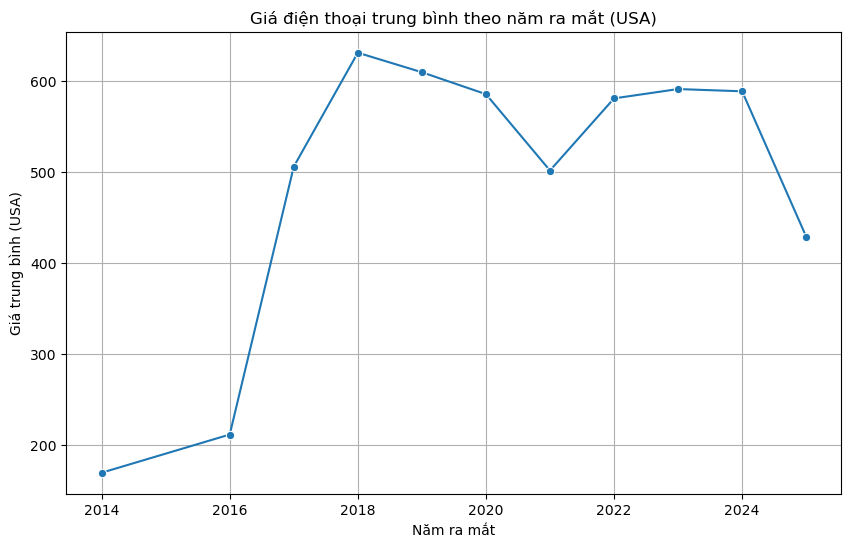

In [427]:
# Loại bỏ giá trị thiếu
df_filtered = data[['Launched Year', 'Launched Price (USA)']].dropna()

# Tính hệ số tương quan Pearson
correlation = df_filtered['Launched Year'].corr(df_filtered['Launched Price (USA)'])
print(f"Hệ số tương quan giữa năm ra mắt và giá ra mắt (USA): {correlation:.3f}")

# Tạo bảng trung bình giá theo năm ra mắt
summary = df_filtered.groupby('Launched Year')['Launched Price (USA)'].mean().reset_index()
print(summary)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.lineplot(data=summary, x='Launched Year', y='Launched Price (USA)', marker='o')
plt.title('Giá điện thoại trung bình theo năm ra mắt (USA)')
plt.xlabel('Năm ra mắt')
plt.ylabel('Giá trung bình (USA)')
plt.grid(True)
plt.show()

In [428]:

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
# Select only numerical columns
numeric_features = [
    'RAM', 'ROM', 'Mobile Weight', 'Battery Capacity', 
    'Front Camera', 'Back Camera', 'Launched Year'
]

passthrough_features = [
    'Launched Price (USA)',
    'Company_Apple','Company_Honor', 'Company_Oppo', 'Company_Other', 'Company_Samsung',
    'Company_Vivo', 'Processor_vec1', 'Processor_vec2', 'Processor_vec3'
]

# scale the data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', 'passthrough', passthrough_features)
    ],
    remainder='drop'  # Drop any other columns not specified
)
all_features = numeric_features + passthrough_features
preprocessor.fit(data)
transformed_data = preprocessor.transform(data)
data_processed = pd.DataFrame(
    transformed_data,
    columns=all_features,
    index=data.index
)

# Check for missing values
data_processed.isnull().sum()

# Now you can use describe()
print(data_processed.describe())


                RAM           ROM  Mobile Weight  Battery Capacity  \
count  9.150000e+02  9.150000e+02   9.150000e+02      9.150000e+02   
mean   4.076885e-17  3.494472e-17   2.019029e-16     -1.383229e-16   
std    1.000547e+00  1.000547e+00   1.000547e+00      1.000547e+00   
min   -2.130114e+00 -1.254419e+00  -8.850925e-01     -2.220270e+00   
25%   -5.615848e-01 -4.883480e-01  -4.138658e-01     -4.618033e-01   
50%    6.582679e-02 -4.883480e-01  -3.196205e-01     -2.218663e-02   
75%    6.582679e-02  3.871620e-01  -1.876770e-01      5.108282e-02   
max    2.575473e+00  1.264430e+01   4.741354e+00      4.520519e+00   

       Front Camera   Back Camera  Launched Year  Launched Price (USA)  \
count  9.150000e+02  9.150000e+02   9.150000e+02            908.000000   
mean  -1.688995e-16  2.038442e-16   1.025045e-14            573.706916   
std    1.000547e+00  1.000547e+00   1.000547e+00            386.605655   
min   -1.343102e+00 -1.333827e+00  -4.392269e+00             79.000000   

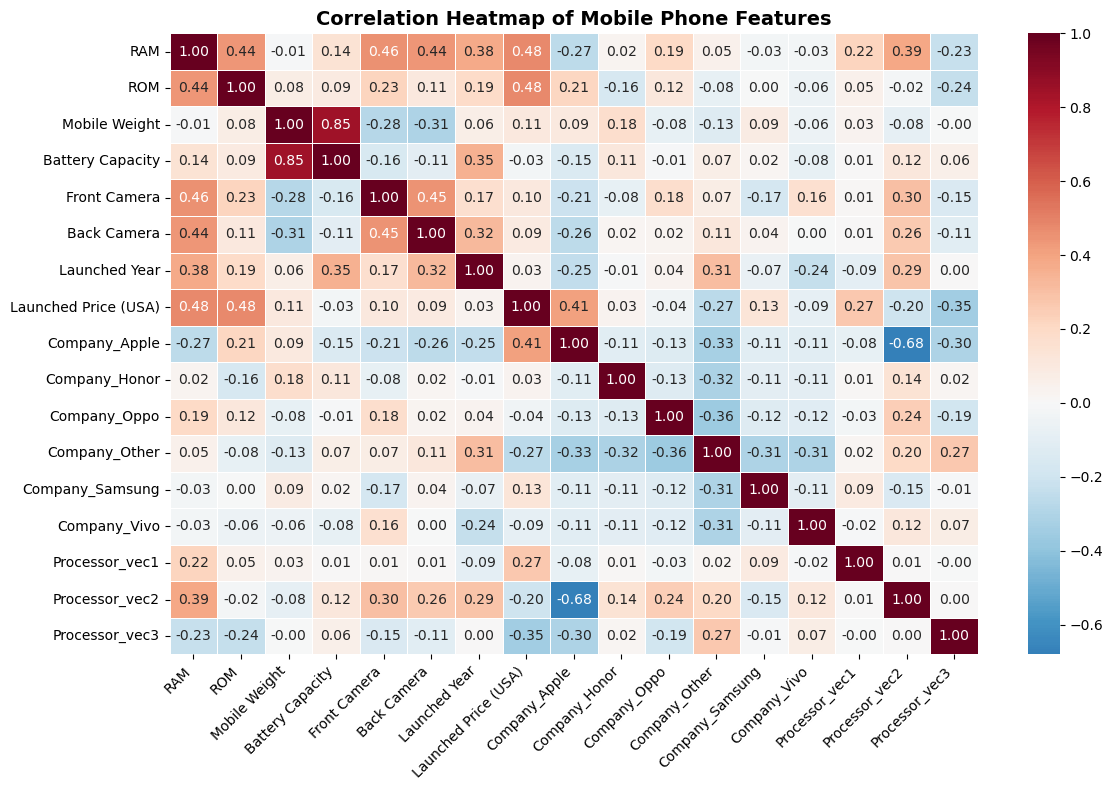

In [429]:
# Compute correlation matrix for numeric features
corr_matrix = data_processed.corr()

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap="RdBu_r", 
            center=0, 
            fmt=".2f", 
            linewidths=0.5)
plt.title("Correlation Heatmap of Mobile Phone Features", 
          fontsize=14, 
          fontweight="bold")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [430]:
from sklearn.pipeline import Pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])


# Verify features are present in data
print("Numeric features present:", all(col in data.columns for col in numeric_features))
print("Passthrough features present:", all(col in data.columns for col in passthrough_features))

Numeric features present: True
Passthrough features present: True


In [431]:
# First drop NA values from original data
data.dropna(inplace=True)

# Split features and target before preprocessing
y = data['Launched Price (USA)']
X = data[numeric_features + passthrough_features]  # Use only selected features

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit and transform preprocessor on training data
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Train model
model = Pipeline([
    ('regressor', LinearRegression())
])

model.fit(X_train_processed, y_train)

# Evaluate
score = model.score(X_test_processed, y_test)
print(f"Model trained successfully")
print(f"R-squared on test set: {score:.4f}")

y_pred = model.predict(X_test_processed)
print("\nPrediction completed.")

Model trained successfully
R-squared on test set: 1.0000

Prediction completed.


In [432]:
model.fit(X_train, y_train)

score = model.score(X_test, y_test)
print(f"Mô hình đã được huấn luyện.")

print(f"R-squared trên tập test: {score:.4f}")

y_pred = model.predict(X_test)
print("\nHoàn thành dự đoán.")

Mô hình đã được huấn luyện.
R-squared trên tập test: 1.0000

Hoàn thành dự đoán.


In [433]:

import pickle

# Save vectorizer and PCA
def save_preprocessor_components():
    """Save preprocessor components needed for new predictions"""
    
    # Company names list
    top_companies = ['Apple', 'Samsung', 'Oppo', 'Honor', 'Vivo']
    
    # Save top companies list
    with open('top_companies.pkl', 'wb') as f:
        pickle.dump(top_companies, f)
    
    # Assuming vectorizer and pca are from your preprocessing notebook
    vectorizer = TfidfVectorizer(stop_words='english', max_features=30)
    processor_texts = data["Processor"].fillna("").astype(str)
    vectorizer.fit(processor_texts)
    
    with open('processor_vectorizer.pkl', 'wb') as f:
        pickle.dump(vectorizer, f)
        
    # PCA
    pca = PCA(n_components=3, random_state=42)
    processor_tfidf = vectorizer.transform(processor_texts)
    pca.fit(processor_tfidf.toarray())
    
    with open('processor_pca.pkl', 'wb') as f:
        pickle.dump(pca, f)
        
    print("Saved preprocessor components: top_companies.pkl, processor_vectorizer.pkl, processor_pca.pkl")

# Run this after training your model
save_preprocessor_components()


Saved preprocessor components: top_companies.pkl, processor_vectorizer.pkl, processor_pca.pkl
